Environment requirements:
*   Python 3
*   PyTorch
*   NumPy
*   Nibabel (for MRI data)
*   Matplotlib
*   Scikit-learn (for evaluation)

# Data Loading

To segment the three tumor sub-regions (Enhancing Tumor (ET), Edema (ED), and Necrotic/Non-enhancing Tumor (NCR/NET)) using the BraTS20 dataset, we'll need to process the data accordingly and ensure your models are designed to output the three sub-regions. 
Dataset Organization In the BraTS20 dataset, the segmentation labels are defined as follows:

*   Label 1: NCR/NET (Necrotic/Non-enhancing Tumor)
*   Label 2: ED (Edema)
*   Label 4: ET (Enhancing Tumor)

In [13]:
import os
import nibabel as nib
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

class BraTSDataset(Dataset):
    def __init__(self, root_dir, validation=False, transform=None):
        self.root_dir = root_dir
        if validation:
            self.subject_dirs = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.startswith("BraTS20_Validation")]
        else:
            self.subject_dirs = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.startswith("BraTS20_Training")]
        self.transform = transform

    def __len__(self):
        return len(self.subject_dirs)

    def __getitem__(self, idx):
        subject_path = self.subject_dirs[idx]
        flair = nib.load(os.path.join(subject_path, f'{os.path.basename(subject_path)}_flair.nii')).get_fdata()
        t1 = nib.load(os.path.join(subject_path, f'{os.path.basename(subject_path)}_t1.nii')).get_fdata()
        t1ce = nib.load(os.path.join(subject_path, f'{os.path.basename(subject_path)}_t1ce.nii')).get_fdata()
        t2 = nib.load(os.path.join(subject_path, f'{os.path.basename(subject_path)}_t2.nii')).get_fdata()

        # For training data, we load segmentation masks
        if 'Training' in os.path.basename(subject_path):
            seg = nib.load(os.path.join(subject_path, f'{os.path.basename(subject_path)}_seg.nii')).get_fdata()

            # Extract tumor sub-regions
            et = (seg == 4).astype(float)  # Enhancing Tumor
            ed = (seg == 2).astype(float)  # Edema
            ncr_net = (seg == 1).astype(float)  # Necrotic/Non-enhancing Tumor
            segmentation = torch.tensor([et, ed, ncr_net], dtype=torch.float32)
        else:
            # No segmentation for validation data
            segmentation = None

        # Stack modalities along the channel dimension
        image = torch.tensor([flair, t1, t1ce, t2], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, segmentation

# Set dataset paths
train_dataset_path = r"D:\Seneca Study\2024-2025\BDA700 - Health Analytics\Project\archive\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData"
validation_dataset_path = r"D:\Seneca Study\2024-2025\BDA700 - Health Analytics\Project\archive\BraTS2020_ValidationData\MICCAI_BraTS2020_ValidationData"

# Create datasets
train_dataset = BraTSDataset(train_dataset_path)
validation_dataset = BraTSDataset(validation_dataset_path, validation=True)

# Testing the Train Dataset
for i in range(3):  # Try loading the first 5 subjects from training data
    try:
        image, segmentation = train_dataset[i]
        print(f"Loaded training sample {i} successfully")
    except FileNotFoundError as e:
        print(f"Error: {e}")

# Testing the Validation Dataset
for i in range(5):  # Try loading the first 5 subjects from validation data
    try:
        image, segmentation = validation_dataset[i]
        if segmentation is None:
            print(f"Loaded validation sample {i} successfully (No segmentation)")
    except FileNotFoundError as e:
        print(f"Error: {e}")


Loaded training sample 0 successfully
Loaded training sample 1 successfully
Loaded training sample 2 successfully
Loaded validation sample 0 successfully (No segmentation)
Loaded validation sample 1 successfully (No segmentation)
Loaded validation sample 2 successfully (No segmentation)
Loaded validation sample 3 successfully (No segmentation)
Loaded validation sample 4 successfully (No segmentation)


# Data Visualization

In [9]:
# Visualization Function:
def visualize_data_sample(image, segmentation):
    # Get the middle slice along the axial direction
    slice_idx = image.shape[1] // 2

    # Extract modalities
    flair = image[0, slice_idx, :, :]
    t1 = image[1, slice_idx, :, :]
    t1ce = image[2, slice_idx, :, :]
    t2 = image[3, slice_idx, :, :]

    # Extract segmentation masks for different tumor regions
    et = segmentation[0, slice_idx, :, :]  # Enhancing Tumor
    ed = segmentation[1, slice_idx, :, :]  # Edema
    ncr_net = segmentation[2, slice_idx, :, :]  # Necrotic/Non-enhancing Tumor

    # Plotting MRI Modalities
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))

    # Plot FLAIR, T1, T1ce, T2
    axes[0, 0].imshow(flair, cmap='gray')
    axes[0, 0].set_title('FLAIR')

    axes[0, 1].imshow(t1, cmap='gray')
    axes[0, 1].set_title('T1')

    axes[0, 2].imshow(t1ce, cmap='gray')
    axes[0, 2].set_title('T1ce')

    axes[0, 3].imshow(t2, cmap='gray')
    axes[0, 3].set_title('T2')

    # Plot segmentation masks for each tumor sub-region
    axes[1, 0].imshow(et, cmap='hot')
    axes[1, 0].set_title('Enhancing Tumor (ET)')

    axes[1, 1].imshow(ed, cmap='hot')
    axes[1, 1].set_title('Edema (ED)')

    axes[1, 2].imshow(ncr_net, cmap='hot')
    axes[1, 2].set_title('Necrotic/Non-enhancing Tumor (NCR/NET)')

    # Overlay segmentation masks on FLAIR image
    axes[1, 3].imshow(flair, cmap='gray')
    axes[1, 3].imshow(et, cmap='Reds', alpha=0.5)
    axes[1, 3].imshow(ed, cmap='Greens', alpha=0.5)
    axes[1, 3].imshow(ncr_net, cmap='Blues', alpha=0.5)
    axes[1, 3].set_title('Overlay (FLAIR + Masks)')

    # Adjust layout for better visualization
    plt.tight_layout()
    plt.show()

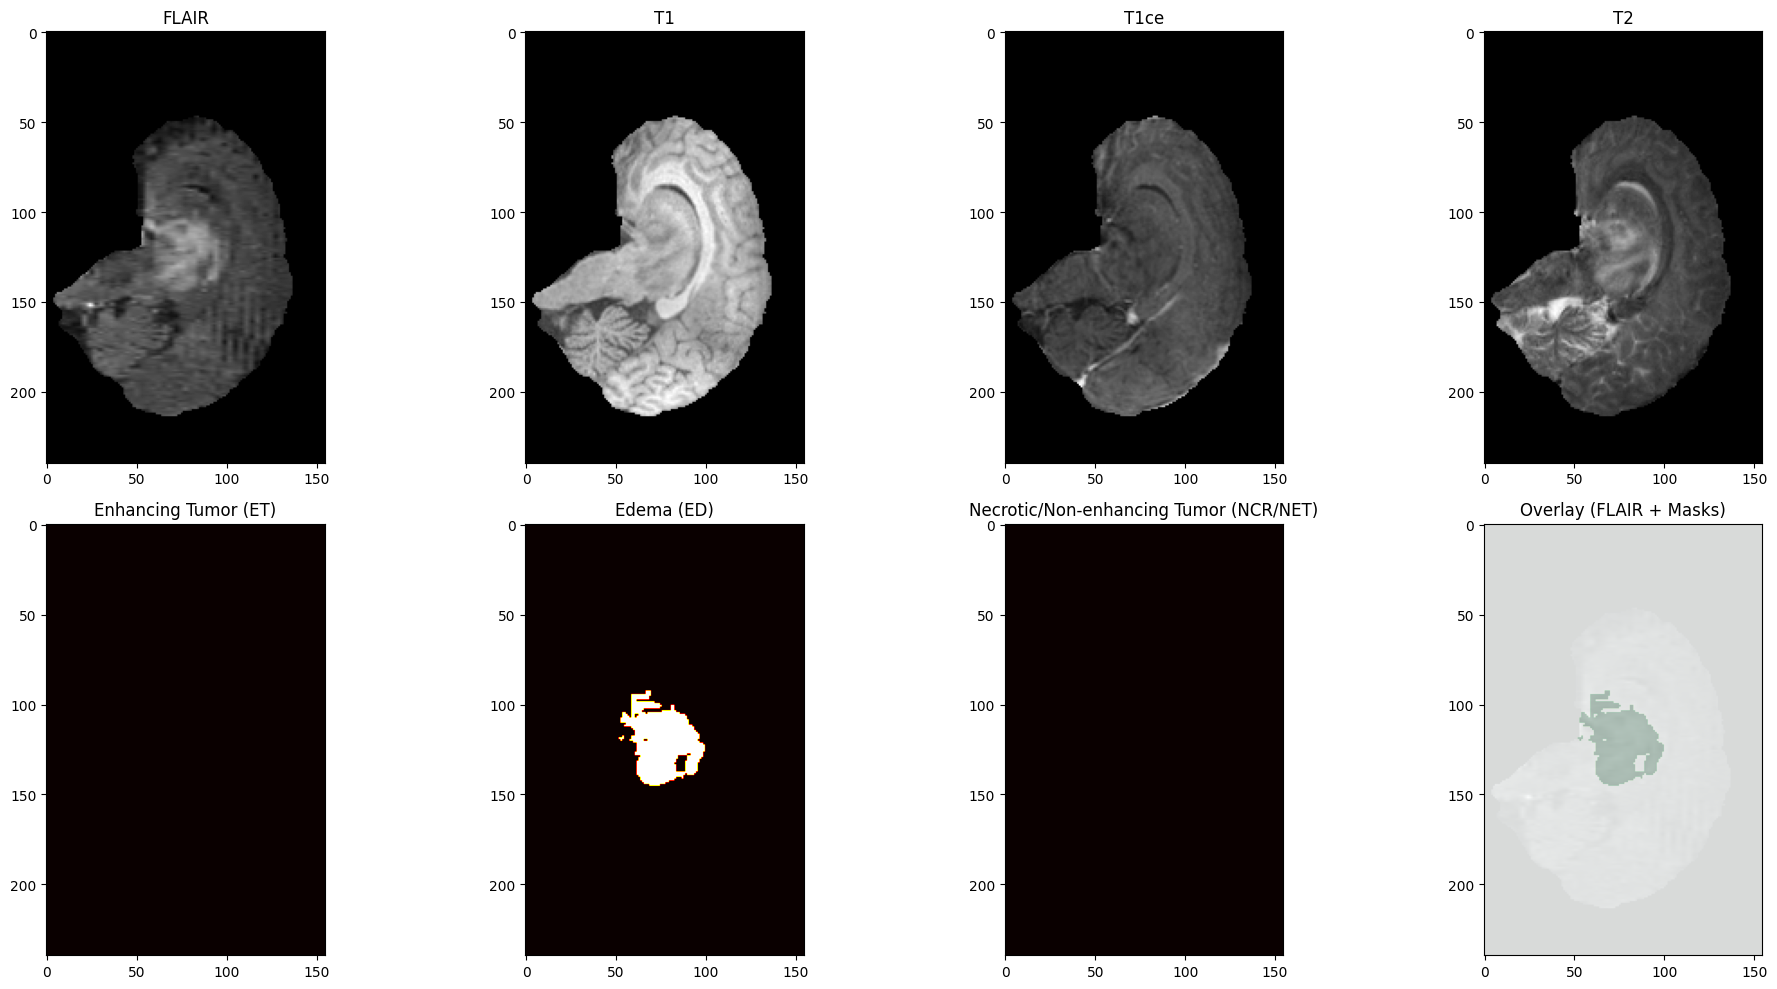

In [10]:
# Visualize a sample from the dataset
# Visualize a sample from the dataset
image, segmentation = train_dataset[0]
visualize_data_sample(image, segmentation)

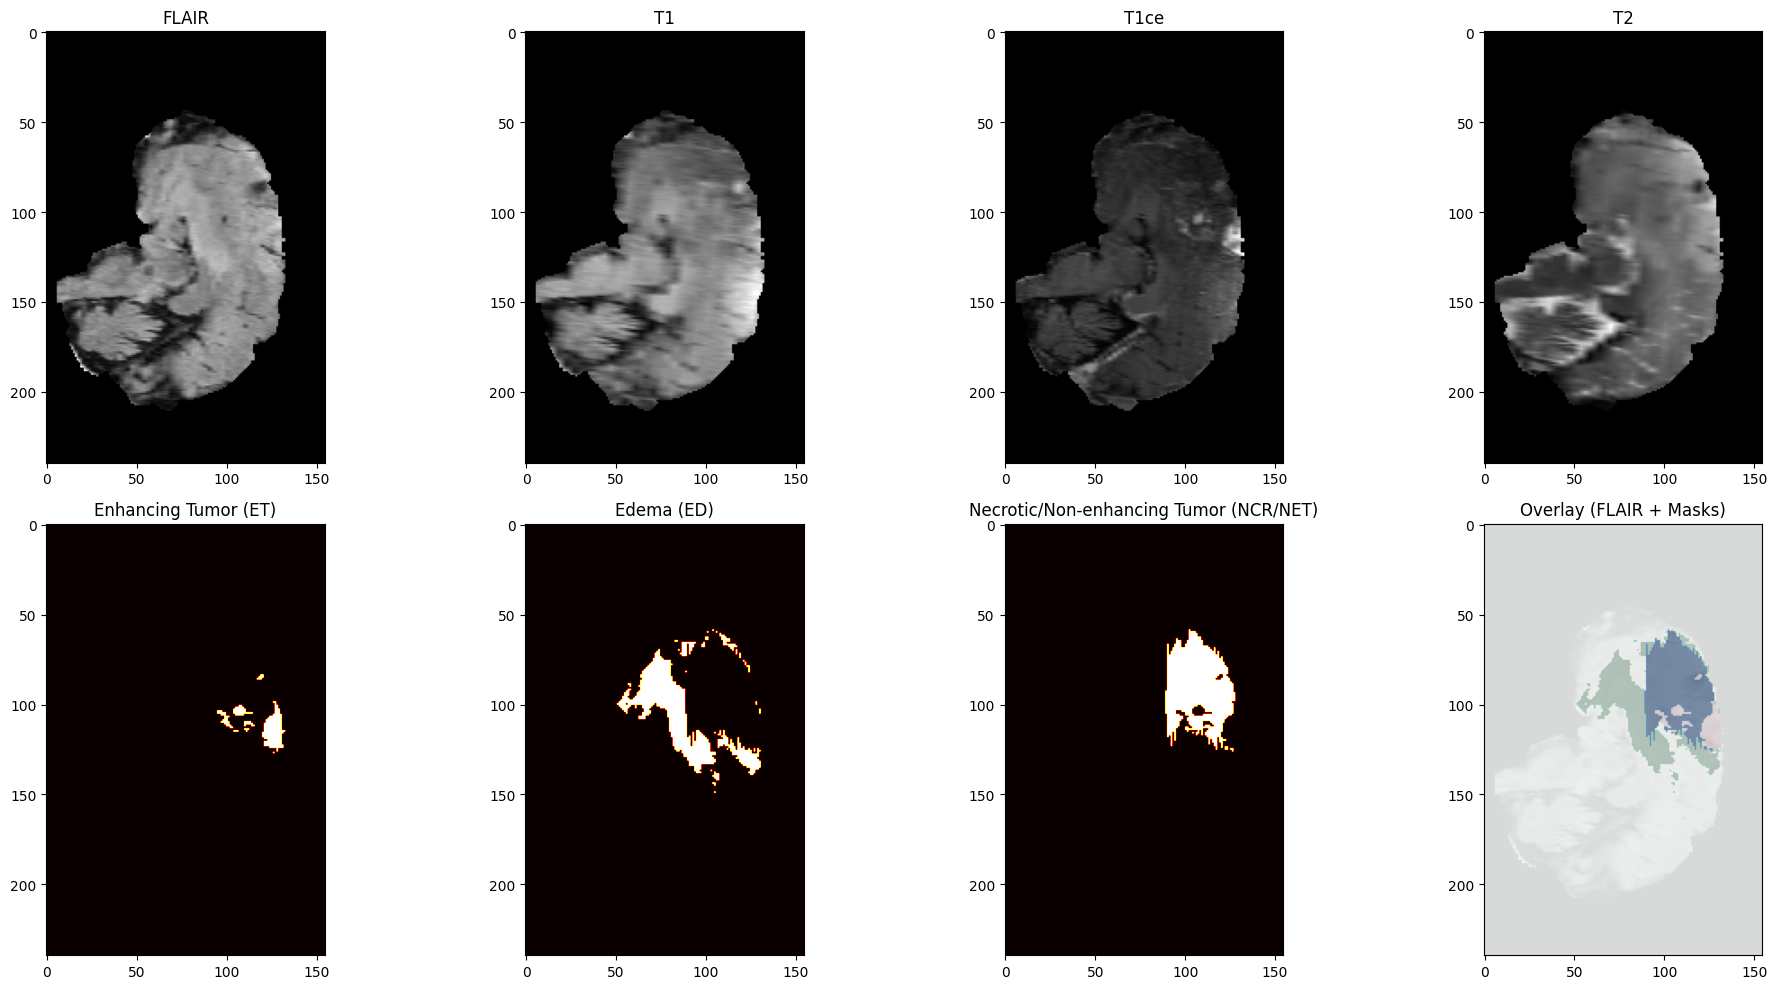

In [12]:
# Visualize a sample from the dataset
image, segmentation = train_dataset[300]
visualize_data_sample(image, segmentation)

# Segmentation Model

## I. 3D GAN models for tumor segmentation

### Step 1: Define 3D GAN Models

Generator Model: To take a latent vector and create a synthetic 3D image.

In [14]:
import torch.nn as nn

class Generator3D(nn.Module):
    def __init__(self, z_dim=100, out_channels=4):
        super(Generator3D, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose3d(z_dim, 64, kernel_size=4, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose3d(64, 32, kernel_size=4, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose3d(32, out_channels, kernel_size=4, stride=2),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)


Discriminator Model: To take in either a real or a synthetic 3D MRI scan and decide if it’s real or fake.

In [18]:
class Discriminator3D(nn.Module):
    def __init__(self, in_channels=4):
        super(Discriminator3D, self).__init__()
        self.model = nn.Sequential(
            nn.Conv3d(in_channels, 32, kernel_size=4, stride=2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d(32, 64, kernel_size=4, stride=2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d(64, 128, kernel_size=4, stride=2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.AdaptiveAvgPool3d(1),  # Pool to a single value per batch element
            nn.Flatten(),             # Flatten the output to match the target size
            nn.Linear(128, 1),        # Output a single value for real or fake prediction
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)



## Step 2: Initialize Models and Optimizers

Early Stopping

In [24]:
import numpy as np

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = np.Inf
        self.early_stop = False

    def __call__(self, validation_loss):
        if validation_loss < self.best_loss - self.delta:
            self.best_loss = validation_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [25]:
z_dim = 100
generator = Generator3D(z_dim=z_dim)
discriminator = Discriminator3D()

lr = 0.0002
betas = (0.5, 0.999)

optimizer_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=betas)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=betas)

criterion = nn.BCELoss()


Generate Samples During Training: Compare these generated images to the real ones to understand how well the GAN is learning.

In [31]:
import matplotlib.pyplot as plt

def visualize_generated_sample(generator, z_dim, epoch, device):
    generator.eval()
    with torch.no_grad():
        z = torch.randn(1, z_dim, 1, 1, 1).to(device)
        fake_image = generator(z).cpu().squeeze()

    slice_idx = fake_image.shape[1] // 2  # Get the middle slice

    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    ax[0].imshow(fake_image[0, slice_idx, :, :], cmap='gray')
    ax[0].set_title('Generated FLAIR')
    ax[1].imshow(fake_image[1, slice_idx, :, :], cmap='gray')
    ax[1].set_title('Generated T1')
    ax[2].imshow(fake_image[2, slice_idx, :, :], cmap='gray')
    ax[2].set_title('Generated T1ce')
    ax[3].imshow(fake_image[3, slice_idx, :, :], cmap='gray')
    ax[3].set_title('Generated T2')

    plt.suptitle(f'Epoch {epoch} - Generated Samples')
    plt.show()

## Step 3: Training Loop: 
train both the generator and the discriminator alternatively

Key Notes on Training Loop Code:
* Device Management: The code handles GPU availability (cuda or cpu).
* Learning Rate Scheduler: Uses ReduceLROnPlateau to reduce the learning rate if the validation loss does not improve.
* Early Stopping: Monitors the validation loss to stop training early if no improvement is detected.
* Logging: Uses TensorBoard (SummaryWriter) to log generator and discriminator losses for monitoring during training.
* Visual Evaluation: Logs generated images every 10 epochs to evaluate generator output.
* Loss Accumulation: Average losses are computed for each epoch to monitor training performance.

In [ ]:
import torch
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

generator = generator.to(device)
discriminator = discriminator.to(device)

num_epochs = 50
batch_size = 2
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
d_losses = []
g_losses = []

# Scheduler for reducing learning rate
scheduler_g = ReduceLROnPlateau(optimizer_g, mode='min', patience=5, factor=0.5, verbose=True)
scheduler_d = ReduceLROnPlateau(optimizer_d, mode='min', patience=5, factor=0.5, verbose=True)

writer = SummaryWriter()
early_stopping = EarlyStopping(patience=5)

for epoch in range(num_epochs):
    epoch_d_loss = 0.0
    epoch_g_loss = 0.0
    
    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)

        # Train Discriminator
        optimizer_d.zero_grad()

        # Real images
        real_labels = torch.ones(real_images.size(0), 1).to(device)
        output_real = discriminator(real_images)
        loss_real = criterion(output_real, real_labels)

        # Fake images
        z = torch.randn(real_images.size(0), z_dim, 1, 1, 1).to(device)
        fake_images = generator(z)
        fake_labels = torch.zeros(real_images.size(0), 1).to(device)
        output_fake = discriminator(fake_images.detach())
        loss_fake = criterion(output_fake, fake_labels)

        # Total loss and backward
        loss_d = loss_real + loss_fake
        loss_d.backward()
        optimizer_d.step()

        # Train Generator
        optimizer_g.zero_grad()

        fake_labels = torch.ones(real_images.size(0), 1).to(device)  # Trick discriminator to think fakes are real
        output_fake = discriminator(fake_images)
        loss_g = criterion(output_fake, fake_labels)

        loss_g.backward()
        optimizer_g.step()

        # Accumulate losses for the epoch
        epoch_d_loss += loss_d.item()
        epoch_g_loss += loss_g.item()

    # Average epoch loss
    epoch_d_loss /= len(train_loader)
    epoch_g_loss /= len(train_loader)
    
    d_losses.append(epoch_d_loss)
    g_losses.append(epoch_g_loss)

    # Log scalar losses
    writer.add_scalar('Loss/Generator', epoch_g_loss, epoch)
    writer.add_scalar('Loss/Discriminator', epoch_d_loss, epoch)

    # Update scheduler at the end of epoch
    validation_loss = epoch_d_loss  # Use discriminator loss as proxy for validation loss
    scheduler_g.step(validation_loss)
    scheduler_d.step(validation_loss)
    
    # Early stopping check
    early_stopping(validation_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

    # Visualize generated samples every 10 epochs
    if (epoch + 1) % 10 == 0:
        visualize_generated_sample(generator, z_dim, epoch + 1, device)
        
    # Log generated images every few epochs
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            z = torch.randn(1, z_dim, 1, 1, 1).to(device)
            fake_image = generator(z).cpu().squeeze()
            writer.add_image(f'Generated Image at Epoch {epoch + 1}', fake_image, epoch)

    # Plot losses after each epoch
    if (epoch + 1) % 10 == 0:
        plt.figure(figsize=(10, 5))
        plt.plot(d_losses, label='Discriminator Loss')
        plt.plot(g_losses, label='Generator Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('GAN Training Losses')
        plt.show()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss D: {epoch_d_loss:.4f}, Loss G: {epoch_g_loss:.4f}')

writer.close()


cuda


C:\Users\dpdca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/50], Loss D: 1.2733, Loss G: 0.4915


In [ ]:
# Save model
torch.save(generator.state_dict(), 'generator_epoch_{}.pth'.format(epoch))
torch.save(discriminator.state_dict(), 'discriminator_epoch_{}.pth'.format(epoch))

# # Load model
# generator.load_state_dict(torch.load('generator_epoch_50.pth'))
# discriminator.load_state_dict(torch.load('discriminator_epoch_50.pth'))
